## Using Word2Vec in non-NLP context

In this notebook, we enconde movies' cast and crew into vectors and use them  to predict the probability of any given movie being among the 1% with most IMDB votes.

When a categorical variable can take such a huge number of possible values, such as the actors/actresses involved in movies, it becomes hard to apply one-hot encoding and use every person as a dummy variable and not overfit badly. There are ways around this though. Another option is to compute features regarding each actor/actress (such as avg number of votes in his/her previous movies) and include those interval variables in a model. In this case we do something different, and try to learn representations for each actor/actress (100 length vectors) using **Word2Vec**.

Even though Word2Vec was originally designed to produce word embeddings, you can use it for any case in which the context matters. In this case, we use actors' and actresses' names (or imdb id's) as the words that would usually be the input of a **Word2Vec** model, and the other actors and actresses who appeared in the same movies, as *context words*.

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, f1_score, fbeta_score, precision_score, recall_score
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import ParameterGrid
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm.notebook import tqdm
import csv
# from gensim.models.callbacks import CallbackAny2Vec
from itertools import groupby
from gensim.models import Word2Vec
# import gensim
from pathlib import Path
import matplotlib.pyplot as plt
import os
import random
import collections
import pickle
from sklearn.preprocessing import MinMaxScaler
pd.options.display.max_columns = 999

### EDA function

進行資料探索

In [2]:
def data_overview(df):
    print("Rows :  " , df.shape[0])
    print("Columns:  " , df.shape[1] )
    a = df.isnull().T.sum()
    print('Missing Value row : ' , a[a > 0].shape[0]) #isnull.sum()會對每條series做sum up ，所以我們還要取出value做一次sum up .
    print('Missing Value of each columns :')
    print(df.isnull().sum())
    print('\nUnique values :')
    print(df.nunique())
    
def data_overview_basics(df):
    print("Rows :  " , df.shape[0])
    print("Columns:  " , df.shape[1] )
    a = df.isnull().T.sum()
    print('Missing Value number : ' , a[a > 0].shape[0]) #isnull.sum()會對每條series做sum up ，所以我們還要取出value做一次sum up .
    print('Missing Value of each columns :')
    print(df.isnull().sum())

def outlier(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3-q1
    lower_bound  = q1-1.5*IQR
    higher_bound = q3+1.5*IQR
    print('\noutlier number:')
    for index in lower_bound.index:
        print(str(index)+':', df[index][(df[index] < lower_bound[index]) | (df[index] > higher_bound[index])].shape[0])   

### 原本三個檔案的資料探索

In [2]:
title_basics = pd.read_csv('title.basics.tsv', sep='\t')
title_ratings = pd.read_csv('title.ratings.tsv', sep='\t')
title_principals = pd.read_csv('title.principals.tsv', sep='\t')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
title_basics.genres = title_basics.genres.apply(
    lambda x: x.split(',') if ((type(x)!=float) & (x!=r'\N')) else np.nan)

title_basics.runtimeMinutes = (title_basics.runtimeMinutes.apply(
    lambda x: np.nan if not x.isdigit() else x).astype(float))

title_basics['startYear'] = title_basics['startYear'].apply(lambda x: np.nan if x == r'\N' else int(x))
title_basics['endYear'] = title_basics['endYear'].apply(lambda x: np.nan if x == r'\N' else int(x))

In [6]:
title_basics

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1.0,"[Documentary, Short]"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5.0,"[Animation, Short]"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,NaN,4.0,"[Animation, Comedy, Romance]"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,NaN,"[Animation, Short]"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1.0,"[Comedy, Short]"
...,...,...,...,...,...,...,...,...,...
6326540,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2010.0,NaN,NaN,"[Action, Drama, Family]"
6326541,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010.0,NaN,NaN,"[Action, Drama, Family]"
6326542,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010.0,NaN,NaN,"[Action, Drama, Family]"
6326543,tt9916856,short,The Wind,The Wind,0,2015.0,NaN,27.0,[Short]


In [15]:
data_overview_basics(title_basics)
print('\nUnique values :')
print(title_basics.iloc[:, :7].nunique())

Rows :   6326545
Columns:   9
Missing Value number :  6299893
Missing Value of each columns :
tconst                  0
titleType               0
primaryTitle           10
originalTitle          10
isAdult                 0
startYear          371185
endYear           6272061
runtimeMinutes    4459212
genres             501660
dtype: int64

Unique values :
tconst           6326545
titleType             10
primaryTitle     3175907
originalTitle    3191724
isAdult                9
startYear            147
endYear               94
dtype: int64


In [8]:
title_ratings

,tconst,averageRating,numVotes
0,tt0000001,5.6,1550
1,tt0000002,6.1,186
2,tt0000003,6.5,1207
3,tt0000004,6.2,113
4,tt0000005,6.1,1934
...,...,...,...
993816,tt9916576,5.9,7
993817,tt9916578,9.1,11
993818,tt9916720,5.1,41
993819,tt9916766,6.7,11


In [16]:
data_overview(title_ratings)

Rows :   993821
Columns:   3
Missing Value row :  0
Missing Value of each columns :
tconst           0
averageRating    0
numVotes         0
dtype: int64

Unique values :
tconst           993821
averageRating        91
numVotes          17360
dtype: int64


In [4]:
title_principals['job'] = title_principals['job'].apply(lambda x: np.nan if x == r'\N' else x)
title_principals['characters'] = title_principals['characters'].apply(lambda x: np.nan if x == r'\N' else x)

In [11]:
title_principals

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,NaN,"[""Herself""]"
1,tt0000001,2,nm0005690,director,NaN,NaN
2,tt0000001,3,nm0374658,cinematographer,director of photography,NaN
3,tt0000002,1,nm0721526,director,NaN,NaN
4,tt0000002,2,nm1335271,composer,NaN,NaN
...,...,...,...,...,...,...
36499699,tt9916880,5,nm0996406,director,principal director,NaN
36499700,tt9916880,6,nm1482639,writer,NaN,NaN
36499701,tt9916880,7,nm2586970,writer,books,NaN
36499702,tt9916880,8,nm1594058,producer,producer,NaN


In [17]:
data_overview(title_principals)

Rows :   36499704
Columns:   6
Missing Value row :  36499704
Missing Value of each columns :
tconst               0
ordering             0
nconst               0
category             0
job           30505144
characters    17965033
dtype: int64

Unique values :
tconst        5710740
ordering           10
nconst        3873199
category           12
job             32211
characters    2207711
dtype: int64


### 合併檔案

I impose a couple of conditions to make the dataset more manageable:

1- Only load movies from after 1960, as I suspect films older than that have a different voting pattern. The choice of 1960 as the cutoff is kind of subjective though.

2- Only load movies > 60 minutes long. It appears that the convention of the minimum duration to be considered a movie is either 40 or 80 minutes depending on the source. So I take 60 minutes which is in the middle of both and makes sense to me.

3- Only load movies with at least 15 votes. With this we get rid of entries that are not even worth looking into (less than 15 votes means that not even the people involved in the movie appears to have voted for it).

In [3]:
with open(('original_df.pk'), 'rb') as f:
    movies = pickle.load(f)

In [14]:
movies

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
15494,tt0015724,movie,Dama de noche,Dama de noche,0,1993,\N,102.0,"[Drama, Mystery, Romance]",6.2,20
34816,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,\N,118.0,"[Comedy, Fantasy, Romance]",6.4,75303
35980,tt0036606,movie,"Another Time, Another Place","Another Time, Another Place",0,1983,\N,118.0,[Drama],6.5,234
38772,tt0039442,movie,"Habla, mudita","Habla, mudita",0,1973,\N,88.0,[Drama],6.2,123
41698,tt0042423,movie,The Dungeon of Harrow,The Dungeon of Harrow,0,1962,\N,86.0,[Horror],3.3,432
...,...,...,...,...,...,...,...,...,...,...,...
6320163,tt9914458,video,Alien Messiah,Alien Messiah,0,2019,\N,75.0,"[Documentary, Sci-Fi]",2.9,40
6320232,tt9914598,video,Cannabis Evolution,Cannabis Evolution,0,2019,\N,70.0,[Documentary],7.9,27
6320255,tt9914644,movie,9/11: Escape from the Towers,9/11: Escape from the Towers,0,2018,\N,120.0,[Documentary],8.4,27
6320857,tt9915928,tvEpisode,Sunn Lo Bhai With Zakir,Sunn Lo Bhai With Zakir,0,2019,\N,64.0,[Comedy],7.8,34


### 處理 cast 跟 crew

In [4]:
with open(('ordered_cast.pk'), 'rb') as f:
    ordered_cast = pickle.load(f)
with open(('ordered_crew.pk'), 'rb') as f:
    ordered_crew = pickle.load(f)

In [16]:
ordered_cast

,tconst,cast
0,tt0000005,"[nm0443482, nm0653042]"
1,tt0000007,"[nm0179163, nm0183947]"
2,tt0000008,[nm0653028]
3,tt0000009,"[nm0063086, nm0183823, nm1309758]"
4,tt0000011,[nm3692297]
...,...,...
3598986,tt9916848,"[nm5519557, nm8825009, nm5262613, nm8690065]"
3598987,tt9916850,"[nm5519557, nm8825009, nm5262613, nm8690065]"
3598988,tt9916852,"[nm5519557, nm8825009, nm5262613, nm8690065]"
3598989,tt9916856,"[nm3394271, nm10538650, nm10538646, nm10538647]"


In [17]:
ordered_crew

,tconst,crew
0,tt0000001,"[nm1588970, nm0005690, nm0374658]"
1,tt0000002,"[nm0721526, nm1335271]"
2,tt0000003,"[nm0721526, nm5442194, nm1335271, nm5442200]"
3,tt0000004,"[nm0721526, nm1335271]"
4,tt0000005,"[nm0005690, nm0249379]"
...,...,...
5133063,tt9916848,"[nm2900202, nm5519454, nm5519375, nm6182221, n..."
5133064,tt9916850,"[nm2900202, nm5519454, nm5519375, nm6182221, n..."
5133065,tt9916852,"[nm2900202, nm5519454, nm5519375, nm6182221, n..."
5133066,tt9916856,"[nm10538645, nm6951431, nm10538653, nm9228549]"


### 處理為合併至原本 Data

In [5]:
movies = pd.merge(movies, ordered_cast, on='tconst', how='left').merge(ordered_crew, on='tconst', how='left')

將空值轉為'Unknown'

In [6]:
movies['cast'].fillna('Unknown', inplace=True)
movies['crew'].fillna('Unknown', inplace=True)

### 增加change_name欄位

In [7]:
imdb_df = movies.copy()
imdb_df['change_name'] = np.where(imdb_df['primaryTitle'] != imdb_df['originalTitle'], 1, 0)
imdb_df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,cast,crew,change_name
0,tt0015724,movie,Dama de noche,Dama de noche,0,1993,\N,102.0,"[Drama, Mystery, Romance]",6.2,20,"[nm0844752, nm0869732, nm0194720, nm0650495]","[nm1457911, nm0529960, nm1597742, nm0600039, n...",0
1,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,\N,118.0,"[Comedy, Fantasy, Romance]",6.4,75303,"[nm0000212, nm0413168, nm0000630, nm0005227]","[nm0107463, nm0003506, nm0737216, nm0465298, n...",0
2,tt0036606,movie,"Another Time, Another Place","Another Time, Another Place",0,1983,\N,118.0,[Drama],6.5,234,"[nm0517642, nm0561155, nm0168856, nm0914908]","[nm0005683, nm0705535, nm0450407, nm0485392, n...",0
3,tt0039442,movie,"Habla, mudita","Habla, mudita",0,1973,\N,88.0,[Drama],6.2,123,"[nm0007023, nm0544330, nm0019330, nm0370455]","[nm0651204, nm0349426, nm0305869, nm0006280, n...",0
4,tt0042423,movie,The Dungeon of Harrow,The Dungeon of Harrow,0,1962,\N,86.0,[Horror],3.3,432,"[nm0367706, nm0389534, nm0574106, nm0120684]","[nm0102124, nm0305239, nm0751113, nm0396837]",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203516,tt9914458,video,Alien Messiah,Alien Messiah,0,2019,\N,75.0,"[Documentary, Sci-Fi]",2.9,40,Unknown,"[nm7520582, nm3033272, nm4378729]",0
203517,tt9914598,video,Cannabis Evolution,Cannabis Evolution,0,2019,\N,70.0,[Documentary],7.9,27,Unknown,"[nm10537327, nm10537326, nm8065995, nm3032813]",0
203518,tt9914644,movie,9/11: Escape from the Towers,9/11: Escape from the Towers,0,2018,\N,120.0,[Documentary],8.4,27,Unknown,"[nm10537376, nm1215463]",0
203519,tt9915928,tvEpisode,Sunn Lo Bhai With Zakir,Sunn Lo Bhai With Zakir,0,2019,\N,64.0,[Comedy],7.8,34,"[nm9501331, nm10235352]","[nm9948942, nm8821619, nm8379182, nm2881024, n...",0


### 合併之後的資料探索

In [20]:
data_overview_basics(imdb_df)
print('\nUnique values :')
print(imdb_df.drop(columns=['genres', 'cast', 'crew']).nunique())

Rows :   203521
Columns:   14
Missing Value number :  29146
Missing Value of each columns :
tconst                0
titleType             0
primaryTitle          0
originalTitle         0
isAdult               0
startYear             0
endYear               0
runtimeMinutes        0
genres                0
averageRating         0
numVotes              0
cast              23068
crew               6078
change_name           0
dtype: int64

Unique values :
tconst            203521
titleType             10
primaryTitle      179791
originalTitle     184669
isAdult                2
startYear             59
endYear               62
runtimeMinutes       557
averageRating         91
numVotes           15433
change_name            2
dtype: int64


觀察 runtimeMinutes、averageRating、numVotes 三個欄位的離群值

In [21]:
outlier(imdb_df.drop(columns=['isAdult', 'startYear', 'change_name']))


outlier number:
runtimeMinutes: 13930
averageRating: 3409
numVotes: 31593


觀察類別欄位的資料分布

In [22]:
imdb_df['isAdult'].value_counts()

0    199316
1      4205
Name: isAdult, dtype: int64

In [23]:
imdb_df['change_name'].value_counts()

0    166064
1     37457
Name: change_name, dtype: int64

In [24]:
imdb_df['titleType'].value_counts()

movie           137967
tvEpisode        22131
tvMovie          19483
video            10582
tvSeries          7881
tvSpecial         2863
tvMiniSeries      2587
videoGame           22
short                3
tvShort              2
Name: titleType, dtype: int64

### 資料視覺化

### 觀察 startYear、averageRating 兩個欄位的資料分布

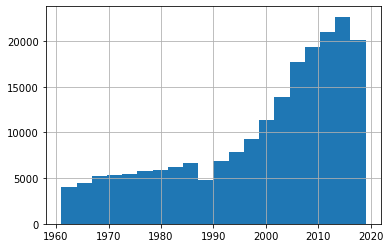

In [10]:
imdb_df['startYear'].hist(bins=20)

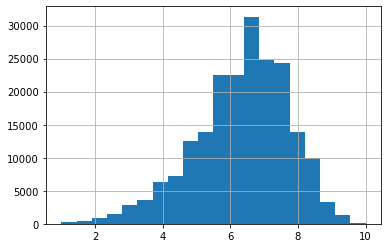

In [11]:
imdb_df['averageRating'].hist(bins=20)

### 各年度電影數量

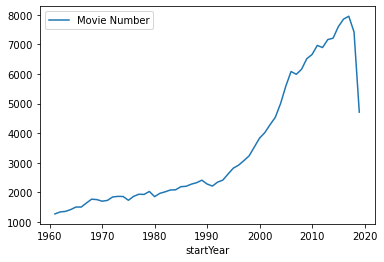

In [26]:
year_num = imdb_df.value_counts('startYear')
year_num_df = pd.DataFrame(year_num, columns = ['Movie Number'])

year_num_df = year_num_df.sort_index()

year_num_df.plot()

### 各種 Genre（電影種類）的數量

In [27]:
genre_list = []
total_genre = []

for i in imdb_df['genres']:
    for j in i:
        total_genre.append(j)
        if j not in genre_list:
            genre_list.append(j)

In [28]:
count = 0
genre_count = []

for i in genre_list:
    for j in total_genre:
        if j == i:
            count += 1
    genre_count.append(count)
    count = 0

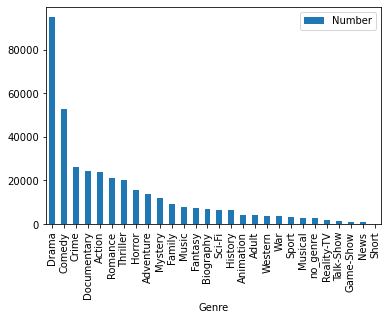

In [29]:
genre = {'Genre': genre_list, 'Number': genre_count}
genre_df = pd.DataFrame(genre)
genre_df = genre_df.sort_values(by = 'Number', ascending = False)
genre_df.plot.bar(x = 'Genre', y = 'Number')

### 各種 Genre（電影種類）的平均分數

In [30]:
genre_list.sort()
genre_ratings = imdb_df[['averageRating']].copy()
for i in genre_list:
    genre_ratings[i] = 0
    
# one-hot
for genre in genre_list:
    genre_ratings[genre] = (imdb_df['genres'].apply(lambda x: 1 if genre in x else 0)).values

In [66]:
genre_rating = {}
for genre in genre_list:
    genre_rating[genre] = genre_ratings[genre_ratings[genre] == 1]['averageRating'].mean()

genre_df['averageRating'] = genre_rating.values()
genre_df = genre_df.sort_values(by = 'averageRating', ascending = False)

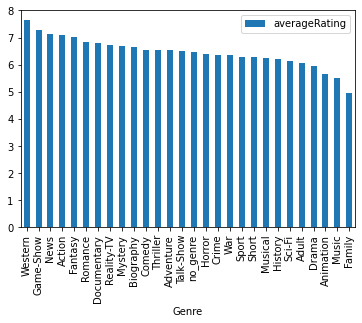

In [69]:
ax = genre_df.plot.bar(x = 'Genre', y = 'averageRating')
ax.legend(loc='upper right')

### 電影分類是成人限制級跟非成人限制級的平均分數

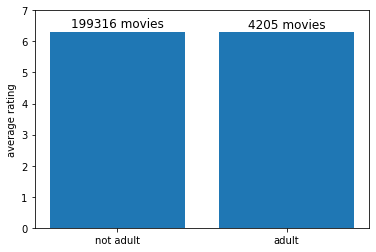

In [200]:
isAdult_rate = imdb_df[imdb_df['isAdult'] == 1]['averageRating'].mean()
notAdult_rate = imdb_df[imdb_df['isAdult'] == 0]['averageRating'].mean()
x = ['not adult', 'adult']
y = [notAdult_rate, isAdult_rate]
plt.bar(x, y)
plt.yticks(range(8))
plt.ylabel("average rating")
i = 0
for a,b in zip(x,y):
    plt.text(a, b+0.05, str(imdb_df['isAdult'].value_counts().values[i]) + ' movies', ha='center', va= 'bottom',fontsize=12)
    i += 1
plt.show()

### 電影有改標題跟沒改標題的平均分數

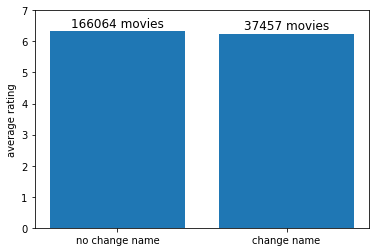

In [201]:
change_name_rate = imdb_df[imdb_df['change_name'] == 1]['averageRating'].mean()
not_change_name_rate = imdb_df[imdb_df['change_name'] == 0]['averageRating'].mean()
x = ['no change name', 'change name']
y = [not_change_name_rate, change_name_rate]
plt.bar(x, y)
plt.yticks(range(8))
plt.ylabel("average rating")
i = 0
for a,b in zip(x,y):
    plt.text(a, b+0.05, str(imdb_df['change_name'].value_counts().values[i]) + ' movies', ha='center', va= 'bottom',fontsize=12)
    i += 1
plt.show()

### 電影不同 title 的平均分數

In [35]:
title_rating_dic = {}
for title in imdb_df['titleType'].value_counts().index:
    title_rating_dic[title] = imdb_df[imdb_df['titleType'] == title]['averageRating'].mean()
    
title_rating_df = pd.DataFrame.from_dict(title_rating_dic, orient='index').reset_index().rename(columns = {'index':'title', 0:'averageRating'})

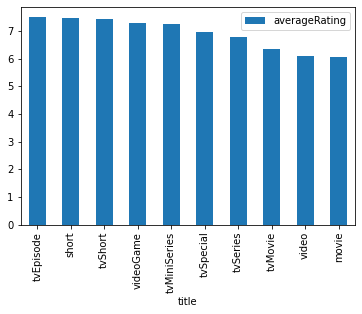

In [72]:
title_rating_df = title_rating_df.sort_values(by = 'averageRating', ascending = False)
ax = title_rating_df.plot.bar(x = 'title', y = 'averageRating')
ax.legend(loc='upper right')

### 觀察隨著時間出來的電影平均分數變化

In [115]:
startYear_dic = {}
for year in imdb_df['startYear'].value_counts().index:
    startYear_dic[year] = imdb_df[imdb_df['startYear'] == year]['averageRating'].mean()
    
startYear_df = pd.DataFrame.from_dict(startYear_dic, orient='index').reset_index().rename(columns = {'index':'startYear', 0:'averageRating'}).sort_values(by = 'startYear')

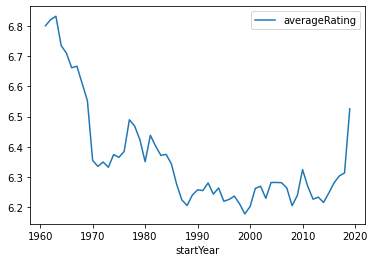

In [116]:
ax = startYear_df.plot(x = 'startYear', y = 'averageRating')
ax.legend(loc='upper right')

### 觀察不同電影長度的平均分數

In [12]:
runtimeMinutes_dic = {}
for minutes in imdb_df['runtimeMinutes'].value_counts().index:
    runtimeMinutes_dic[minutes] = imdb_df[imdb_df['runtimeMinutes'] == minutes]['averageRating'].mean()
    
runtimeMinutes_df = pd.DataFrame.from_dict(runtimeMinutes_dic, orient='index').reset_index().rename(columns = {'index':'runtimeMinutes', 0:'averageRating'}).sort_values(by = 'runtimeMinutes')
# 轉成小時
runtimeMinutes_df['runtimeMinutes'] /= 60

In [13]:
runtimeHours_dic = {}
for i in range(0, 20, 2):
    runtimeHours_dic[str(i)+' - '+str(i+2)+' hr'] = runtimeMinutes_df[(runtimeMinutes_df['runtimeMinutes'] >= i) & (runtimeMinutes_df['runtimeMinutes'] < i + 2)]['averageRating'].mean()
runtimeHours_dic['> 20 hr'] = runtimeMinutes_df[(runtimeMinutes_df['runtimeMinutes'] >= 20)]['averageRating'].mean()

runtimeHours_df = pd.DataFrame.from_dict(runtimeHours_dic, orient='index').reset_index().rename(columns = {'index':'runtimeHours', 0:'averageRating'})

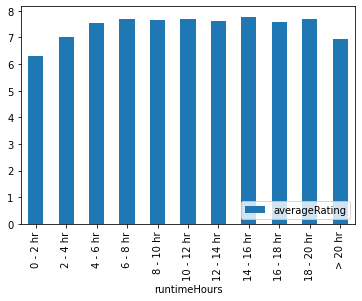

In [14]:
ax = runtimeHours_df.plot.bar(x = 'runtimeHours', y = 'averageRating')
ax.legend(loc='lower right')

### 觀察不同票數的電影平均分數

In [204]:
numVotes_dic = {}
for votes in imdb_df['numVotes'].value_counts().index:
    numVotes_dic[votes] = imdb_df[imdb_df['numVotes'] == votes]['averageRating'].mean()
    
numVotes_df = pd.DataFrame.from_dict(numVotes_dic, orient='index').reset_index().rename(columns = {'index':'numVotes', 0:'averageRating'}).sort_values(by = 'numVotes')

In [205]:
numVotes_interval_dic = {}
for i in range(1, 1000000, 100000):
    numVotes_interval_dic[str((i-1)/1000)+'k - '+str((i+100000-1)/1000)+'k votes'] = numVotes_df[(numVotes_df['numVotes'] >= i) & (numVotes_df['numVotes'] < i + 100000)]['averageRating'].mean()
numVotes_interval_dic['> 1000k votes'] = numVotes_df[(numVotes_df['numVotes'] >= 1000000)]['averageRating'].mean()

numVotes_interval_df = pd.DataFrame.from_dict(numVotes_interval_dic, orient='index').reset_index().rename(columns = {'index':'numVotes', 0:'averageRating'})

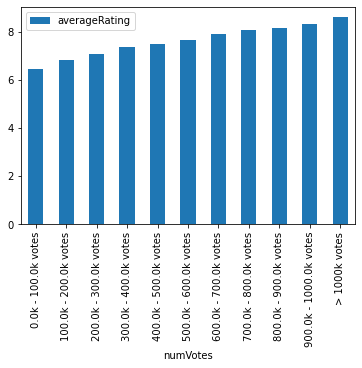

In [206]:
ax = numVotes_interval_df.plot.bar(x = 'numVotes', y = 'averageRating')
# ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

### 觀察與演員、幕後人員相關的視覺化

In [4]:
with open('total_cast.pickle', 'rb') as f:
    total_cast = pickle.load(f)
with open('total_crew.pickle', 'rb') as f:
    total_crew = pickle.load(f)

### 進行演員視覺化的爬蟲函式

In [3]:
from IPython.display import HTML, display
from bs4 import BeautifulSoup
import requests

def get_name(id):
    response = requests.get(f'https://www.imdb.com/name/{id}/')
    soup = BeautifulSoup(response.content)
    return soup.select('.header .itemprop')[0].text

def get_image(id):
    response = requests.get(f'https://www.imdb.com/name/{id}/')
    soup = BeautifulSoup(response.content)
    candidates = soup.select('#name-poster')
    return candidates[0].attrs['src'] if candidates else 'https://m.media-amazon.com/images/G/01/imdb/images/nopicture/medium/name-2135195744._CB466677935_.png'

def render_person(id):
    name = get_name(id)
    picture = get_image(id)
    return f"""
    <div style="width: 150px; text-align: center">
        <h4 style='margin-top: -5px'>{name}</h4>
        <div style='font-size:75%; margin-bottom: 5px'>{id}</div>
        <a href="https://www.imdb.com/name/{id}" target="_blank">
            <img style="width: 100px; display: block; margin-left: auto; margin-right: auto;" src="{picture}"/>
        </a>
    </div>
    """

In [5]:
total_cast = total_cast.drop(total_cast[total_cast['total cast'] == 'U'].index)
total_cast = total_cast.drop(total_cast[total_cast['total cast'] == 'N'].index)
total_cast = total_cast.drop(total_cast[total_cast['total cast'] == 'K'].index)
total_cast = total_cast.drop(total_cast[total_cast['total cast'] == 'O'].index)
total_cast = total_cast.drop(total_cast[total_cast['total cast'] == 'W'].index)
total_cast = total_cast.drop(total_cast[total_cast['total cast'] == 'u'].index)
total_cast = total_cast.drop(total_cast[total_cast['total cast'] == 'n'].index)
total_cast = total_cast.drop(total_cast[total_cast['total cast'] == 'k'].index)
total_cast = total_cast.drop(total_cast[total_cast['total cast'] == 'o'].index)
total_cast = total_cast.drop(total_cast[total_cast['total cast'] == 'w'].index)
total_cast = total_cast.reset_index(drop = True)

total_crew = total_crew.drop(total_crew[total_crew['total crew'] == 'U'].index)
total_crew = total_crew.drop(total_crew[total_crew['total crew'] == 'N'].index)
total_crew = total_crew.drop(total_crew[total_crew['total crew'] == 'K'].index)
total_crew = total_crew.drop(total_crew[total_crew['total crew'] == 'O'].index)
total_crew = total_crew.drop(total_crew[total_crew['total crew'] == 'W'].index)
total_crew = total_crew.drop(total_crew[total_crew['total crew'] == 'u'].index)
total_crew = total_crew.drop(total_crew[total_crew['total crew'] == 'n'].index)
total_crew = total_crew.drop(total_crew[total_crew['total crew'] == 'k'].index)
total_crew = total_crew.drop(total_crew[total_crew['total crew'] == 'o'].index)
total_crew = total_crew.drop(total_crew[total_crew['total crew'] == 'w'].index)
total_crew = total_crew.reset_index(drop = True)

In [6]:
cast_count = total_cast.pivot_table(columns = ['total cast'], aggfunc = 'size')
cast_count
cast_df = pd.DataFrame({'Cast': cast_count.index, 'Movie number': cast_count})

crew_count = total_crew.pivot_table(columns = ['total crew'], aggfunc = 'size')
crew_count
crew_df = pd.DataFrame({'Crew': crew_count.index, 'Movie number': crew_count})

In [7]:
cast_df = cast_df.reset_index(drop=True).sort_values('Movie number', ascending = False)
crew_df = crew_df.reset_index(drop=True).sort_values('Movie number', ascending = False)

In [8]:
cast_top10 = cast_df.iloc[:10, :].reset_index(drop=True)
crew_top10 = crew_df.iloc[:10, :].reset_index(drop=True)

In [9]:
cast_rating = []
for cast in cast_top10['Cast']:
    tmp = 0
    i = 0
    for idx, cast_li in imdb_df['cast'].iteritems():
        if cast in cast_li:
            tmp += imdb_df.loc[idx, 'averageRating']
            i += 1
    cast_rating.append(tmp / i)

NameError: name 'imdb_df' is not defined

In [66]:
cast_top10['averageRating'] = cast_rating
cast_top10

,Cast,Movie number,averageRating
0,nm0001446,534,7.584831
1,nm0001296,431,7.296984
2,nm0000790,397,7.883627
3,nm0832065,391,7.851407
4,nm0000994,383,7.599478
5,nm0088779,370,7.364324
6,nm0086469,367,7.835422
7,nm0193411,290,7.791034
8,nm0565982,275,7.743273
9,nm0533891,253,6.987352


### 演出前 10 多演員的平均分數

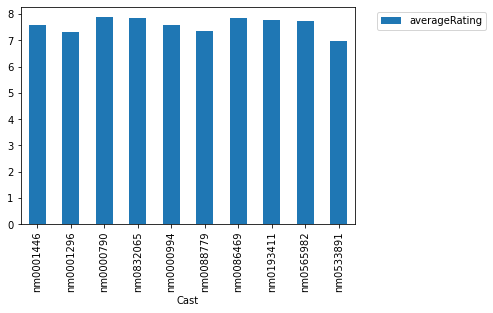

In [67]:
ax = cast_top10.plot.bar(x = 'Cast', y = 'averageRating')
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

### 將演出前 10 多的演員進行視覺化

In [10]:
renders = []
for cast in cast_top10['Cast']:
    renders.append(render_person(cast))
        
carousel = ''.join(
    [
        f'<div style="margin-left: 10px; float: left">{p}</div>' 
        for p in renders
    ]
    )
display(HTML(f'<div style="width: 1800px">{carousel}</div>'))

In [72]:
crew_rating = []
for crew in crew_top10['Crew']:
    tmp = 0
    i = 0
    for idx, crew_li in imdb_df['crew'].iteritems():
        if crew in crew_li:
            tmp += imdb_df.loc[idx, 'averageRating']
            i += 1
    crew_rating.append(tmp / i)

In [73]:
crew_top10['averageRating'] = crew_rating
crew_top10

,Crew,Movie number,averageRating
0,nm0912766,737,7.872456
1,nm0937725,484,7.894215
2,nm0488991,433,7.115704
3,nm0741328,425,7.626824
4,nm0531990,401,7.841397
5,nm0582307,399,7.857143
6,nm0234228,386,7.370466
7,nm0357855,382,7.369895
8,nm0000636,366,7.025683
9,nm0933259,364,6.867582


### 演出前 10 多的幕後人員平均分數

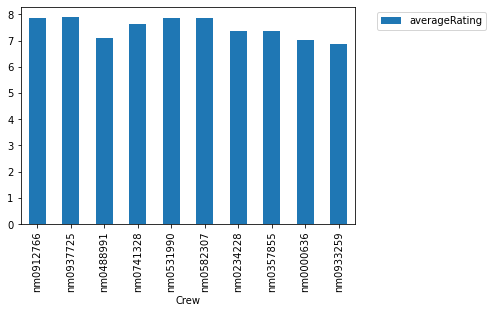

In [74]:
ax = crew_top10.plot.bar(x = 'Crew', y = 'averageRating')
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

### 將演出前 10 多的幕後人員進行視覺化

In [75]:
renders = []
for crew in crew_top10['Crew']:
    renders.append(render_person(crew))
        
carousel = ''.join(
    [
        f'<div style="margin-left: 10px; float: left">{p}</div>' 
        for p in renders
    ]
    )
display(HTML(f'<div style="width: 1800px">{carousel}</div>'))

### w2v

### 利用 word2Vec 的結果，找出相似演員的函式

In [12]:
def show_similars(id, n=10):
    if id in wtv.wv: 
        display(HTML(render_person(id)))
    renders = []
    for similar_id, score in wtv.wv.most_similar(id, topn=n):
        renders.append(render_person(similar_id))
        
    carousel = ''.join(
        [
            f'<div style="margin-left: 10px; float: left">{p}</div>' 
            for p in renders
        ]
        )
    display(HTML(f'<div style="width: 1800px">{carousel}</div>'))

def show_similars_tovector(id, n=10):
    renders = []
    
    for similar_id, score in wtv.wv.most_similar(id, topn=n):
        renders.append(render_person(similar_id))
        
    carousel = ''.join(
        [
            f'<div style="margin-left: 10px; float: left">{p}</div>' 
            for p in renders
        ]
    )
    display(HTML(f'<div style="width: 1800px">{carousel}</div>'))

In [13]:
wtv = Word2Vec.load("bestw2v_model/bestw2v_model")

### 與李奧納多相似的演員

In [104]:
show_similars('nm0000138')

妮可基嫚 多為共同演出之演員

跟 Shailene Woodley 共同出演廣受好評且獲獎無數的『美麗心計』

跟 Robert Downey Jr. 共同出演『皮相獵影』

跟 Hugo Weaving 共同出演『快樂腳』、『陌生之地』、『Strangerland』等戲劇

跟 Robert Pattinson 共同出演『Queen of the Desert』

另外值得注意的是，Tom Cruise 與 Nicole Kidman之間曾經存在婚姻關係

In [14]:
show_similars('nm0000173')

馮迪索 多為動作片演員

包含出演『天能』的 John David Washington

出演『搶救雷恩大兵』的 Barry Pepper

跟甄子丹也共同主演『限制級戰警』

In [16]:
show_similars('nm0004874')

巨石強森 多為摔角選手

跟 John David Washington 共同出演 Ballers（好球天團）（足球）

跟 Paul Levesque 同為摔角選手，曾共同參與世界冠軍摔角（WCW）

跟 Mick Foley 同為摔角選手，曾在 WWE 擊敗巨石強森，拿下 WWE 冠軍

跟 Glenn Jacobs 同為摔角選手

Dennis Knight 也是摔角選手

In [210]:
show_similars('nm0425005')

凱文哈特 多為喜劇演員

跟 Ed Helms 一同出演：凱文·哈特：現在要怎樣？

曾參與演出 J. Cole 的 MV Kevin's Heart

跟 Mike Epps 一同出演：麥克·伊皮斯：一枝獨秀

跟 Jason Segel 一同出演：五年之約

In [211]:
show_similars('nm0366389')

### 利用 word2Vec 的結果進行 K-means 分群

### 分成 50 群

In [159]:
from sklearn.cluster import KMeans
n_clusters = 50
X = wtv.wv.vectors
all_categories = wtv.wv.index_to_key
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
all_categories_labels_kmeans = kmeans.fit_predict(X)
df_kmeans = pd.DataFrame(all_categories_labels_kmeans, index=all_categories, columns=['label'])
for i in range(len(set(all_categories_labels_kmeans))):
    cast = list(df_kmeans[df_kmeans['label'] == i].index)    
    print("cluster " + str(i) + ": ")
    print(list(cast))
    print("=============================================")
    print("=============================================")

cluster 0: 
['nm1414914', 'nm1440222', 'nm9635747', 'nm1251869', 'nm4277116', 'nm2671944', 'nm0488579', 'nm1002677', 'nm1012401', 'nm1486232', 'nm0346004', 'nm1553394', 'nm1747318', 'nm1046223', 'nm0427550', 'nm0379951', 'nm9108676', 'nm0675736', 'nm2620244', 'nm1668673', 'nm1426335', 'nm0188780', 'nm3602323', 'nm7690212', 'nm2590376', 'nm2371196', 'nm0510948', 'nm0197198', 'nm3138348', 'nm3216535', 'nm7376489', 'nm3014915', 'nm1088493', 'nm5731453', 'nm3126571', 'nm2571452', 'nm2396101', 'nm1794765', 'nm1845301', 'nm8094066', 'nm1416784', 'nm5731452', 'nm1415163', 'nm2960352', 'nm2100867', 'nm0261101', 'nm2254468', 'nm0890394', 'nm1031871', 'nm2969609', 'nm1268194', 'nm0727968', 'nm7622097', 'nm5374763', 'nm2122990', 'nm1235452', 'nm9635755', 'nm3836484', 'nm4889700', 'nm2826012', 'nm2468729', 'nm0729131', 'nm5147153', 'nm3014806', 'nm3733234', 'nm1205307', 'nm0748917', 'nm0634303', 'nm2545615', 'nm1540120', 'nm5348232', 'nm3138511', 'nm1037430', 'nm1651027', 'nm3331837', 'nm1898990',

In [161]:
df_kmeans.value_counts()

label
5        8355
13       6317
6        6264
40       3675
15       3607
1        3591
36       2528
18       2354
8        2329
23       2328
34       2269
14       2149
22       2050
33       2027
21       1883
31       1878
46       1877
0        1692
26       1687
11       1685
20       1651
44       1597
17       1525
32       1509
16       1461
30       1442
9        1401
37       1377
45       1304
24       1257
3        1185
10       1153
43       1129
7        1090
35       1024
41       1014
47        957
27        914
19        903
38        892
48        882
2         826
12        727
29        605
4         585
28        568
42        568
49        460
39        421
25        293
dtype: int64

分成 50 群後發現每群的人都很多，因此嘗試直接分成 500 群

In [162]:
from sklearn.cluster import KMeans
n_clusters = 500
X = wtv.wv.vectors
all_categories = wtv.wv.index_to_key
kmeans2 = KMeans(n_clusters=n_clusters, random_state=0)
all_categories_labels_kmeans2 = kmeans2.fit_predict(X)
df_kmeans2 = pd.DataFrame(all_categories_labels_kmeans2, index=all_categories, columns=['label'])
for i in range(len(set(all_categories_labels_kmeans2))):
    cast = list(df_kmeans2[df_kmeans2['label'] == i].index)    
    print("cluster " + str(i) + ": ")
    print(list(cast))
    print("=============================================")
    print("=============================================")

cluster 0: 
['nm0569758', 'nm0630124', 'nm0843381', 'nm0662270', 'nm0936771', 'nm0221461', 'nm1505296', 'nm0829462', 'nm2913856', 'nm0165310', 'nm1046288', 'nm1398616', 'nm0528562', 'nm3511513', 'nm0748917', 'nm3927771', 'nm3339821', 'nm2277047', 'nm3583289', 'nm2973623', 'nm3924283', 'nm4197693', 'nm3879121', 'nm1468636', 'nm0299942', 'nm0850640', 'nm2045439', 'nm4158756', 'nm0415024', 'nm1288256', 'nm6026431', 'nm0412520', 'nm0320471', 'nm3912521', 'nm8872970', 'nm4375257', 'nm3880536', 'nm5923287', 'nm3370453', 'nm3698746', 'nm5682224', 'nm0192053', 'nm9079287', 'nm3777585', 'nm0613328', 'nm2961746', 'nm0669037', 'nm4169278', 'nm0740365', 'nm6032710', 'nm6877150', 'nm1339632', 'nm9623257', 'nm2266085', 'nm5073992', 'nm6965827', 'nm4942172', 'nm0326145', 'nm4895468', 'nm4744218', 'nm4719952', 'nm0071243', 'nm0555049', 'nm1296682', 'nm1140166', 'nm3918299', 'nm3874638', 'nm1937321']
cluster 1: 
['nm0038932', 'nm0200451', 'nm0835646', 'nm0805785', 'nm0321963', 'nm0517372', 'nm0915762',

In [167]:
df_kmeans2.value_counts().tail(50)

label
408      18
49       18
391      17
218      17
462      17
268      16
17       15
272      15
105      14
283      14
298      13
311      13
36       13
293      11
50       10
324      10
122      10
370       9
98        9
254       9
153       9
313       9
65        7
68        7
386       6
29        6
322       6
286       6
442       6
431       5
463       4
470       3
354       3
419       2
193       2
373       1
364       1
352       1
206       1
387       1
308       1
474       1
289       1
406       1
119       1
414       1
453       1
418       1
235       1
355       1
dtype: int64

挑選幾個人數大概 10 個人左右的群體來進行觀察與分析

### 第 122 群有 10 人，幾乎都是墨西哥演員

In [176]:
renders = []
for cast in df_kmeans2[df_kmeans2['label'] == 122].index:
    renders.append(render_person(cast))
        
carousel = ''.join(
    [
        f'<div style="margin-left: 10px; float: left">{p}</div>' 
        for p in renders
    ]
    )
display(HTML(f'<div style="width: 1800px">{carousel}</div>'))

在分群結果中，找第一個人的相似演員，發現分群結果有 4 個人跟 show_similars 的人一樣

In [191]:
show_similars('nm0305955')

### 第 324 群有 10 人，幾乎都是墨西哥人

In [177]:
renders = []
for cast in df_kmeans2[df_kmeans2['label'] == 324].index:
    renders.append(render_person(cast))
        
carousel = ''.join(
    [
        f'<div style="margin-left: 10px; float: left">{p}</div>' 
        for p in renders
    ]
    )
display(HTML(f'<div style="width: 1800px">{carousel}</div>'))

在分群結果中，找第一個人的相似演員，發現分群結果有 4 個人跟 show_similars 的人一樣

In [193]:
show_similars('nm0623021')

### 第 36 群有 12 人，幾乎都是阿根廷人

In [198]:
renders = []
for cast in df_kmeans2[df_kmeans2['label'] == 36].index:
    renders.append(render_person(cast))
        
carousel = ''.join(
    [
        f'<div style="margin-left: 10px; float: left">{p}</div>' 
        for p in renders
    ]
    )
display(HTML(f'<div style="width: 1800px">{carousel}</div>'))

在分群結果中，找第一個人的相似演員，發現分群結果有 5 個人跟 show_similars 的人一樣

In [199]:
show_similars('nm0112868')